In [1]:
%load_ext autoreload
%autoreload 2 

# For svg plots
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from enum import IntEnum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import trange
from collections import defaultdict

from GrU_nn import (gru_module_1, gru_module_2, gru_module_3, gru_module_4, neuralGrU)
from GrU import (evaluate, GrU, getBestExporter, getCost)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

### Load auction data

In [3]:
class clock( IntEnum ):
    pv = 0
    storage = 1
    charge = 2
    discharge = 3

class source( IntEnum ):
    grid =  0
    pv = 1
    storage = 2
    charge = 3
    discharge = 4

df_auctioneer_data = pd.read_csv('../data/Auctioneer Data.csv')

headers = np.load(file='../data/clock_data_columns.npy', allow_pickle=True)
df_clock_data = pd.DataFrame(np.load('../data/clock_data_values.npy', allow_pickle=True), columns=headers)

def getPriceVectors(round):
    '''
    Get price vectors for a round from the clock data.

    Parameters
    ----------
    round : int
        Round number to get the price vectors for, range = [0, 308]

    Returns
    -------
    prices : ndarray of shape (5, 24)
        Price vectors for g, p, s, c, d.
    
    '''
    prices = np.ndarray((5, 24))
    prices[0] = df_auctioneer_data.GRID_PRICE.values
    for e in clock:
        prices[e + 1] = df_clock_data[f'price_{round}'][e]
    return prices

## Revenue Maximisation

In [4]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev

In [41]:
# Init model
B_init = 4
eta = 1
scaler = 1
ep = np.ones(24)

model = neuralGrU(B=B_init, n_agents=1, ep=ep, gamma=[0], eta_c=eta, eta_d=eta, alpha=1e3).to(device)

#### Input Data

In [42]:
# # Price vectors sampled from Uniform Distribution [0, 1)
# prices = np.random.random(size=(5, 24)) * scaler
# prices[1:] = 1e-3

> Hyperparameters: lr = 0.01, gamma = 0.98, B = 16, scaler = 1, Curriculum Learning & ExponentialLR Scheduler

In [43]:
# Price vectors from Auction Data
prices = getPriceVectors(300) * scaler

> Hyperparameters: lr = 1, gamma = 0.92, B = 1, scaler = 1 Curriculum Learning & ExponentialLR Scheduler

In [47]:
# Total demand tensor (Unit)
d_t = torch.ones((1, 24), requires_grad=False, device=device) * 5
# d_t = torch.ones(24, requires_grad=False, device=device)

# Cap tensor
C_p = torch.ones((1, 24), requires_grad=False) * 4
# C_d = torch.ones((1, 24), requires_grad=False) * 4

# Price tensors
pi_g = torch.tensor(prices[source.grid], requires_grad=False, device=device)

pi_p = torch.tensor(prices[source.pv],  requires_grad=True, device=device)
pi_c = torch.tensor(prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(prices[source.storage], requires_grad=True, device=device)

#### Optimisation schedule

In [48]:
# Hyperparameter(s)
learning_rate = 0.008
epochs = 500

history = []
best_loss = 0
model.B = B_init

# Init optimizer & scheduler
optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

for t in trange(epochs):
    # Compute prediction and loss
    d_star = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t, C_p)
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star.squeeze())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Optimisation
    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history.append(loss / scaler)

    if loss < best_loss:
        pi_optimal, best_loss = [], loss
        for pi in pi_p, pi_s, pi_c, pi_d:
            pi_optimal.append(pi.clone().detach())

    # Curriculum Learning
    if t % 10 == 0 and model.B < 1e4:
        model.B *= 2

    # if t % 100 == 0:
    #     print(f"Epoch {t+1}     loss: {loss:>7f}")

100%|██████████| 500/500 [00:02<00:00, 176.51it/s]


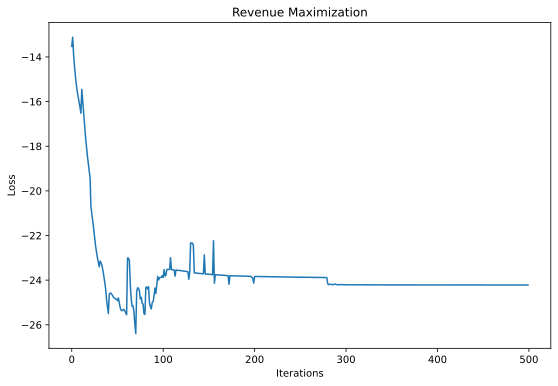

In [50]:
plt.figure(figsize=(9,6))
plt.plot(history, label='loss')
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [51]:
best_loss, loss

(-26.39140590691001, -24.21654694071711)

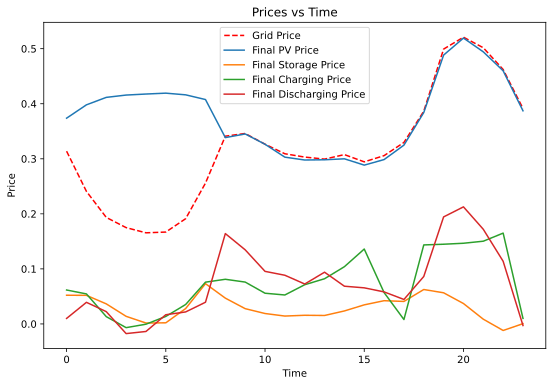

In [63]:
# prices_pv_optimal = pi_optimal[0].numpy()
prices_final = [pi.detach().numpy() for pi in (pi_p, pi_s, pi_c, pi_d)]

plt.figure(figsize=(9,6))
plt.title('Prices vs Time')

plt.plot(prices[source.grid], label='Grid Price', linestyle='dashed', color='red')
plt.plot(prices_final[0], label='Final PV Price')
plt.plot(prices_final[1], label='Final Storage Price')
plt.plot(prices_final[2], label='Final Charging Price')
plt.plot(prices_final[3], label='Final Discharging Price')

plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.show()

In [64]:
torch.round(d_star, decimals=2).round(decimals=1)

tensor([[[ 5.,  5.,  5.,  5., 15.,  5.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,
           1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  4.,  5.,  4.,  4.,  4.,
           4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.],
         [ 0.,  0.,  0.,  0., 10., 10.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  5.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]],
       dtype=torch.float64, grad_fn=<RoundBackward1>)

## Multi-agent Revenue Maximization

In [68]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev


def barrier_loss(C_g, C, epsilon):
    '''
    Barrier function with barrier at C_g & sensitivity epsilon
    '''
    b = F.relu(-torch.log((C_g - C)/epsilon))

    return torch.sum(b)

In [86]:
eta = 1
n_agents = 5
B_init = 64
gamma = [1, 2, 3, 4, 5]

# EI values
ep = [0.00044688, 0.00044796, 0.00045042, 0.00045573, 0.00046029, 0.00046002, 0.00045153, 0.00043737, 0.00042772, 0.00041107, 0.00040774, 0.00038668, 0.00037268, 0.00036565, 0.00036387, 0.00035763, 0.00034319, 0.00034377, 0.00035285, 0.00037902, 0.00039631, 0.00040366, 0.00039713, 0.00039088]
ep_t = np.array(ep) * 1e3

model = neuralGrU(
    B=B_init,
    n_agents=n_agents,
    ep=ep_t,
    gamma=gamma,
    device=device,
    eta_c=eta,
    eta_d=eta,
    alpha=1e3
)

In [87]:
# prices = np.random.random((5, 24))
prices = getPriceVectors(300)
prices[1:] = 1e-3

# Total demand tensor
d_t_n = torch.ones((n_agents, 24), requires_grad=False, device=device) * 2

# Global constraint
C_global = torch.ones(24, requires_grad=False, device=device) * 8

# Price tensors
pi_g = torch.tensor(prices[source.grid], requires_grad=False, device=device)

pi_p = torch.tensor(prices[source.pv], requires_grad=True, device=device)
pi_c = torch.tensor(prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(prices[source.storage], requires_grad=True, device=device)

# Local constraints
C_t_n = torch.ones(size=(n_agents, 24), requires_grad=True, device=device)

In [88]:
# Hyperparameter(s)
learning_rate = 0.01
epochs = 500
epsilon = 0.25
nan = 1e3

history = []
model.B = B_init

optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d, C_t_n], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

for t in trange(epochs):
    d_star_n = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t_n, C_t_n)
    d_total = torch.sum(d_star_n, dim=0)
    C_total = torch.sum(C_t_n, dim=0)

    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_total) + barrier_loss(C_global, C_total, epsilon)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Optimisation
    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history.append(loss)

    if loss < best_loss:
        pi_optimal, best_loss = [], loss
        for pi in pi_p, pi_s, pi_c, pi_d:
            pi_optimal.append(pi.clone().detach())

    # Curriculum Learning
    if t % 10 == 0 and model.B < 1e4:
        model.B *= 2

100%|██████████| 500/500 [00:03<00:00, 152.49it/s]


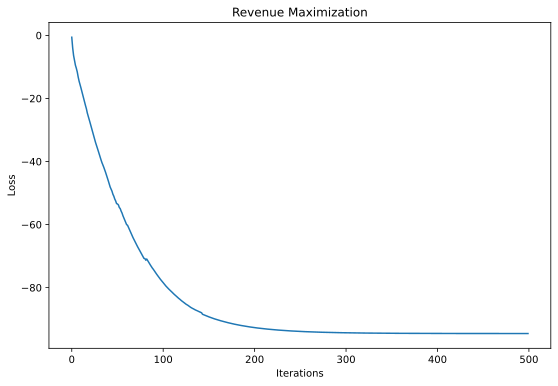

In [89]:
plt.figure(figsize=(9,6))
plt.plot(history)
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

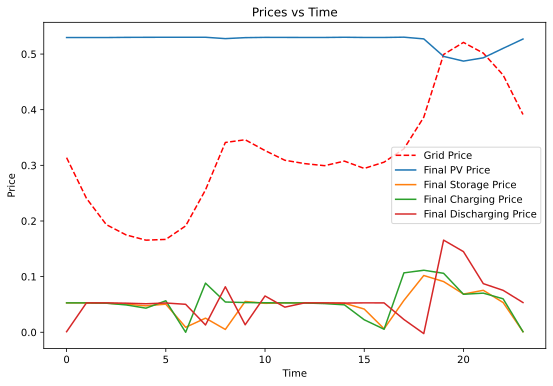

In [90]:
# prices_pv_optimal = pi_optimal[0].numpy()
prices_final = [pi.detach().numpy() for pi in (pi_p, pi_s, pi_c, pi_d)]

plt.figure(figsize=(9,6))
plt.title('Prices vs Time')

plt.plot(prices[source.grid], label='Grid Price', linestyle='dashed', color='red')
plt.plot(prices_final[0], label='Final PV Price')
plt.plot(prices_final[1], label='Final Storage Price')
plt.plot(prices_final[2], label='Final Charging Price')
plt.plot(prices_final[3], label='Final Discharging Price')

plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.show()

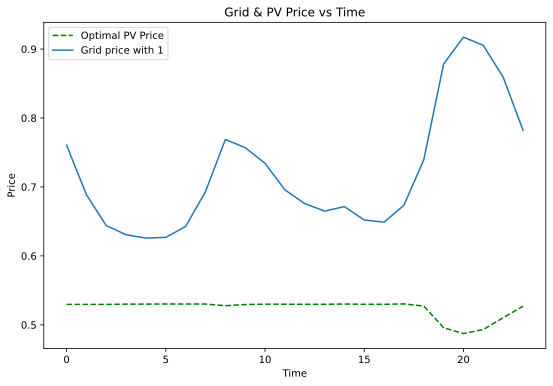

In [91]:
pv_price = pi_p.detach().numpy()
grid_price_ei = (torch.tensor(ep_t) * gamma[0] + pi_g).detach().numpy()

plt.figure(figsize=(9,6))
plt.title('Grid & PV Price vs Time')
plt.plot(pv_price, label='Optimal PV Price', color='g', linestyle='dashed')
plt.plot(grid_price_ei, label=f'Grid price with {gamma[0]}')

plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.show()

### Local PV Constraint

In [93]:
C_t_n

tensor([[1.5500, 1.5500, 1.5500, 1.5628, 1.5673, 1.5511, 1.5486, 1.5139, 1.3729,
         1.4532, 1.4941, 1.5291, 1.5243, 1.5238, 1.5403, 1.5239, 1.5249, 1.5405,
         1.4972, 1.0857, 1.0415, 1.3982, 1.4600, 1.5036],
        [1.5500, 1.5500, 1.5500, 1.5626, 1.5468, 1.5510, 1.5497, 1.5362, 1.3938,
         1.5171, 1.5474, 1.5390, 1.5564, 1.5564, 1.5518, 1.5564, 1.5561, 1.5524,
         1.4926, 1.0658, 1.0088, 0.9797, 1.4210, 1.4963],
        [1.5500, 1.5500, 1.5500, 1.5421, 1.5462, 1.5504, 1.5505, 1.5635, 1.5091,
         1.5718, 1.5535, 1.5606, 1.5564, 1.5566, 1.5524, 1.5565, 1.5563, 1.5526,
         1.4748, 1.0530, 0.9098, 0.8798, 1.1724, 1.4566],
        [1.5500, 1.5500, 1.5500, 1.5415, 1.5453, 1.5494, 1.5508, 1.5669, 1.5369,
         1.5789, 1.5775, 1.5606, 1.5564, 1.5566, 1.5526, 1.5566, 1.5564, 1.5525,
         1.4291, 0.9753, 0.7976, 0.7759, 0.9795, 1.4149],
        [1.5500, 1.5500, 1.5500, 1.5409, 1.5443, 1.5481, 1.5504, 1.5694, 1.5458,
         1.6001, 1.5776, 1.5606, 1.5564

In [94]:
torch.sum(C_t_n, dim=0)

tensor([7.7500, 7.7500, 7.7500, 7.7500, 7.7500, 7.7500, 7.7500, 7.7500, 7.3585,
        7.7210, 7.7500, 7.7500, 7.7500, 7.7500, 7.7500, 7.7500, 7.7500, 7.7500,
        7.2661, 5.1294, 4.5553, 4.8094, 5.9680, 7.2482],
       grad_fn=<SumBackward1>)

### Total PV demand of all agents

In [693]:
torch.sum(d_star_n[:, 1], dim=0)

tensor([7.7500, 7.7500, 7.7363, 7.7500, 7.6846, 7.4882, 4.5999, 6.9299, 7.6683,
        7.7500, 7.7500, 6.1056, 7.7459, 4.5962, 6.0985, 6.2112, 4.5755, 6.2598,
        5.8619, 7.6571, 7.7500, 7.7500, 4.6355, 7.7500], dtype=torch.float64,
       grad_fn=<SumBackward1>)

In [95]:
torch.round(d_star_n[:, 1], decimals=2)

tensor([[1.5500, 1.5500, 1.5500, 1.5600, 1.5700, 1.5500, 1.5500, 1.5100, 1.3700,
         1.4500, 1.4900, 1.5300, 1.5200, 1.5200, 1.5400, 1.5200, 1.5200, 1.5400,
         1.5000, 1.0900, 1.0400, 1.4000, 1.4600, 1.5000],
        [1.5500, 1.5500, 1.5500, 1.5600, 1.5500, 1.5500, 1.5500, 1.5400, 1.3900,
         1.5200, 1.5500, 1.5400, 1.5600, 1.5600, 1.5500, 1.5600, 1.5600, 1.5500,
         1.4900, 1.0700, 1.0100, 0.9800, 1.4200, 1.5000],
        [1.5500, 1.5500, 1.5500, 1.5400, 1.5500, 1.5500, 1.5500, 1.5600, 1.5100,
         1.5700, 1.5500, 1.5600, 1.5600, 1.5600, 1.5500, 1.5600, 1.5600, 1.5500,
         1.4700, 1.0500, 0.9100, 0.8800, 1.1700, 1.4600],
        [1.5500, 1.5500, 1.5500, 1.5400, 1.5500, 1.5500, 1.5500, 1.5700, 1.5400,
         1.5800, 1.5800, 1.5600, 1.5600, 1.5600, 1.5500, 1.5600, 1.5600, 1.5500,
         1.4300, 0.9800, 0.8000, 0.7800, 0.9800, 1.4100],
        [1.5500, 1.5500, 1.5500, 1.5400, 1.5400, 1.5500, 1.5500, 1.5700, 1.5500,
         1.6000, 1.5800, 1.5600, 1.5600

> PV demand of all 5 users

## Revenue Maximisation with Gradient Clipping

(Outdated code)

1. No Curriculum Learning (for B). Init B at 10-20.
2. Gradients clipped at 0, i.e., updates to price(s) are non-negative.
3. Input price tensors are scaled to compensate for lower B.
4. ExponentialLR performs better than ReduceLROnPlateau.

In [ ]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev

In [ ]:
# Init model
eta = 1
B = 256
scaler = 1

model = neuralGrU(B, device, eta, eta).to(device)

#### Input Data

In [ ]:
# prices = getPriceVectors(100) * scaler
scaled_prices = prices * scaler

# Random total demand tensor
d_t = torch.ones(24, requires_grad=False, device=device)
# d_t = torch.ones(24, requires_grad=False, device=device)

# Price tensors
pi_g = torch.tensor(scaled_prices[source.grid] + grid_shift, requires_grad=False, device=device)

pi_p = torch.tensor(scaled_prices[source.pv],  requires_grad=True, device=device)
pi_c = torch.tensor(scaled_prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(scaled_prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(scaled_prices[source.storage], requires_grad=True, device=device)

#### Optimization schedule

In [ ]:
# Hyperparameter(s)
learning_rate = 0.025
epochs = 500

history_grad_clip = []

# Init optimizer & scheduler
optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.982)

for t in trange(epochs):
    # Compute prediction and loss
    d_star = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t)
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    
    # Gradient Clipping
    for p in [pi_p, pi_s, pi_c, pi_d]:
        p.grad = -F.relu(-p.grad)

    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history_grad_clip.append(loss / scaler)

    # Curriculum Learning
    if t % 10 == 0 and model.B < 1e4:
        model.B *= 2

    # if t % 100 == 0:
    #     print(f"Epoch {t+1}     loss: {loss:>7f}")

100%|██████████| 500/500 [00:03<00:00, 162.10it/s]


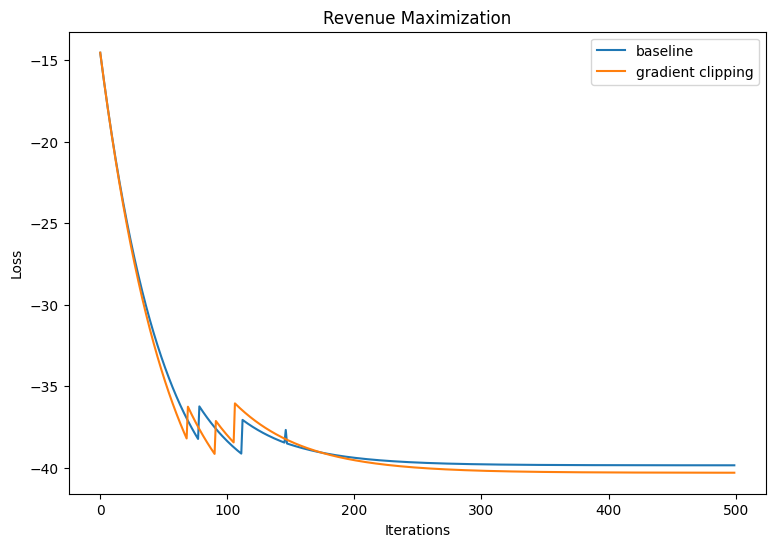

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(history, label='baseline')
plt.plot(history_grad_clip, label='gradient clipping')
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
(pi_g > pi_p).all()

tensor(True)

In [ ]:
(pi_g - pi_p) / scaler

tensor([ 0.3661,  1.8690,  0.5150, -0.0408, -0.0312,  0.8866,  0.1038,  0.3904,
         1.3893,  0.8990,  0.1514,  1.9923,  0.6137,  0.7580,  0.5715,  0.3316,
         0.6517, -0.0619,  0.7804,  0.6153,  0.7038,  1.8420,  1.2148,  0.4223],
       dtype=torch.float64, grad_fn=<DivBackward0>)

In [ ]:
np.round(d_star.detach().numpy())

array([[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])